<a href="https://colab.research.google.com/github/alexlimatds/fact_extraction/blob/main/AILA2020/FACTS_AILA_SBERT_LaBSE_positional_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facts extraction with AILA data, SBERT (LaBSE) and positional encoding

- for training: the train dataset from AILA 2020. This can be obtained at https://github.com/Law-AI/semantic-segmentation;
- for test: additional train documents from AILA 2021;

There are two forms of evaluation: 5-fold cross-validation and with the test set. The data split of the cross-validation approach is done in terms of documents instead sentences.

The features are generated by a SBERT/LaBSE model to represent the documents' sentences. The final features are enriched with positional encoding values in a similar way as the Transformer architecture. In this case, we use the position of each sentence in its documento to compute the positional embedding.


### Notebook parameters

In [1]:
model_id = 'sentence-transformers/LaBSE'

###Installing dependencies

In [2]:
# SBERT
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.4 MB/s 
     |████████████████████████████████| 4.0 MB 11.3 MB/s 
     |████████████████████████████████| 1.2 MB 37.7 MB/s 
     |████████████████████████████████| 84 kB 1.3 MB/s 
     |████████████████████████████████| 880 kB 18.6 MB/s 
     |████████████████████████████████| 596 kB 28.3 MB/s 
     |████████████████████████████████| 6.6 MB 10.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=cbbaa73fd3774e19a73d97e22321c12968ecd9f3b73f41b25edfb6d9817a3b77
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=fb92d7ed0213855fe9202406e9ee9495b226e4535da3392c96afdc5c86afb0d0
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

###Loading dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
g_drive_dir = "/content/gdrive/MyDrive/"
dataset_dir = 'fact_extraction_AILA/'

Mounted at /content/gdrive


In [4]:
!rm -r data
!mkdir data
!mkdir data/train
!tar -xf {g_drive_dir}{dataset_dir}train.tar.xz -C data/train
!mkdir data/test
!tar -xf {g_drive_dir}{dataset_dir}test.tar.xz -C data/test

train_dir = 'data/train/'
test_dir = 'data/test/'

rm: cannot remove 'data': No such file or directory


In [5]:
import pandas as pd
from os import listdir
import csv

def read_docs(dir_name):
  """
  Read the docs in a directory.
  Params:
    dir_name : the directory that contains the documents.
  Returns:
    A dictionary whose keys are the names of the read files and the values are 
    pandas dataframes. Each dataframe has sentence and label columns.
  """
  docs = {} # key: file name, value: dataframe with sentences and labels
  for f in listdir(dir_name):
    df = pd.read_csv(
        dir_name + f, 
        sep='\t', 
        quoting=csv.QUOTE_NONE, 
        names=['sentence', 'label'])
    docs[f] = df
  return docs

docs_train = read_docs(train_dir)
docs_test = read_docs(test_dir)

print(f'TRAIN: {len(docs_train)} documents read.')
print(f'TEST: {len(docs_test)} documents read.')

TRAIN: 50 documents read.
TEST: 10 documents read.


###Features

In [6]:
from sentence_transformers import SentenceTransformer

sent_encoder = SentenceTransformer(model_id)
sent_encoder.max_seq_length = 512

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

In [12]:
import torch
import numpy as np

torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getPositionEncoding(seq_len, d, n=10000):
  """
  Returns a positional encoding matrix.
  Code adapted from https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
  Arguments:
    seq_len : the length of the sequence.
    d : the embedding / encoding dimension.
  Returns:
    A PyTorch tensor with shape (seq_len, d).
  """
  P = torch.zeros((seq_len, d), device=torch_device)
  for k in range(seq_len):
    for i in torch.arange(int(d/2)):
      denominator = np.power(n, 2*i/d)
      P[k, 2*i] = np.sin(k/denominator)
      P[k, 2*i+1] = np.cos(k/denominator)
  return P

In [8]:
def get_features(dic_docs):
  """
  Generates the features for a set of documents.
  Arguments:
    dic_docs : a dictionary as returned by the read_docs function.
  Returns:
    - The features as a numpy matrix. Each line in the matrix is respective to a sentence.
    - A list of strings with respective sentences' labels.
    - A dictionary associating each document with its features. The key is the 
    document ID and the value is a numpy matrix.
  """
  features = None
  labels = []
  features_by_doc = {}
  for doc_id, df in dic_docs.items():
    sentences = df['sentence'].to_list()
    embedding = sent_encoder.encode(sentences, convert_to_tensor=True)
    embedding = embedding + getPositionEncoding(embedding.shape[0], embedding.shape[1])
    features_by_doc[doc_id] = embedding
    if features is None:
      features = embedding
    else:
      features = torch.vstack((features, embedding))
    labels.extend(df['label'].tolist())
  for doc_id, tensor in features_by_doc.items():
    features_by_doc[doc_id] = tensor.detach().to('cpu').numpy()
  return features.detach().to('cpu').numpy(), labels, features_by_doc

In [14]:
%%time
# Train features
train_features, train_targets, docs_train_features = get_features(docs_train)
print(f'{train_features.shape[0]} sentences.')
print(f'Train features shape: {train_features.shape}')

9380 sentences.
Train features shape: (9380, 768)
CPU times: user 17min 12s, sys: 3.54 s, total: 17min 16s
Wall time: 17min 12s


In [13]:
%%time
# Test features
test_features, test_targets, _ = get_features(docs_test)
print(f'{test_features.shape[0]} sentences.')
print(f'Test features shape: {test_features.shape}')

1905 sentences.
Test features shape: (1905, 768)
CPU times: user 3min 32s, sys: 673 ms, total: 3min 33s
Wall time: 3min 33s


### Evaluation functions

In [15]:
# Reading the file containing the sets of trains documents and test documents by fold
train_files_by_fold = {}  # Key: fold ID, value: file names (list of string)
test_files_by_fold = {}   # Key: fold ID, value: file names (list of string)

df_folds = pd.read_csv(
  g_drive_dir + dataset_dir + 'train_docs_by_fold.csv', 
  sep=';', 
  names=['fold id', 'train', 'test'], 
  header=0)

for _, row in df_folds.iterrows():
  train_files_by_fold[row['fold id']] = row['train'].split(',')
  test_files_by_fold[row['fold id']] = row['test'].split(',')

for fold_id in train_files_by_fold.keys():
  print(f'Fold {fold_id}: \n\tTrain files: {train_files_by_fold[fold_id]} \n\tTest files: {test_files_by_fold[fold_id]}')


Fold 0: 
	Train files: ['d_44.txt', 'd_39.txt', 'd_12.txt', 'd_2.txt', 'd_7.txt', 'd_33.txt', 'd_16.txt', 'd_8.txt', 'd_42.txt', 'd_34.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_41.txt', 'd_46.txt', 'd_43.txt', 'd_50.txt', 'd_27.txt', 'd_25.txt', 'd_35.txt', 'd_45.txt', 'd_17.txt', 'd_48.txt', 'd_6.txt'] 
	Test files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt']
Fold 1: 
	Train files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_

In [16]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support

def cross_validation(trainer):
  print('### Evaluation with cross-validation ###')
  train_metrics_cross = []
  test_metrics_cross = []
  for fold_id in train_files_by_fold.keys():
    print(f'Starting fold {fold_id}')
    # train features of the current fold
    train_features_fold = None
    train_targets_fold = []
    for doc_id in train_files_by_fold[fold_id]:
      if train_features_fold is None:
        train_features_fold = docs_train_features[doc_id]
      else:
        train_features_fold = np.vstack((train_features_fold, docs_train_features[doc_id]))
      train_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    #training model
    model = trainer(train_features_fold, train_targets_fold)
    # test features of the current fold
    test_features_fold = None
    test_targets_fold = []
    for doc_id in test_files_by_fold[fold_id]:
      if test_features_fold is None:
        test_features_fold = docs_train_features[doc_id]
      else:
        test_features_fold = np.vstack((test_features_fold, docs_train_features[doc_id]))
      test_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    # test metrics
    predictions = model.predict(test_features_fold)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(
        test_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    test_metrics_cross.append([p_test, r_test, f1_test])
    # train metrics
    predictions = model.predict(train_features_fold)
    p_train, r_train, f1_train, _ = precision_recall_fscore_support(
        train_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    train_metrics_cross.append([p_train, r_train, f1_train])
  
  test_metrics_cross = np.array(test_metrics_cross)
  test_mean = np.mean(test_metrics_cross, axis=0)
  test_std = np.std(test_metrics_cross, axis=0)
  train_metrics_cross = np.array(train_metrics_cross)
  train_mean = np.mean(train_metrics_cross, axis=0)
  train_std = np.std(train_metrics_cross, axis=0)
  
  print(f'Mean precision - std deviation => train: {train_mean[0]:.4f} {train_std[0]:.4f} \t test: {test_mean[0]:.4f} {test_std[0]:.4f}')
  print(f'Mean recall - std deviation    => train: {train_mean[1]:.4f} {train_std[1]:.4f} \t test: {test_mean[1]:.4f} {test_std[1]:.4f}')
  print(f'Mean f1 - std deviation        => train: {train_mean[2]:.4f} {train_std[2]:.4f} \t test: {test_mean[2]:.4f} {test_std[2]:.4f}')


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_metrics = {}

def evaluate_with_test_set(trainer):
  print('### Evaluation with the test set ###')
  # evaluation
  model = trainer(train_features, train_targets)
  predictions = model.predict(test_features)
  # Precision, Recall, F1
  t_metrics = precision_recall_fscore_support(
    test_targets, 
    predictions, 
    average='binary', 
    pos_label='Facts', 
    zero_division=0)
  test_metrics[model.__class__.__name__] = t_metrics
  print(f'Precision: {t_metrics[0]:.4f}')
  print(f'Recall:    {t_metrics[1]:.4f}')
  print(f'F-score:   {t_metrics[2]:.4f}')
  # Confusion matrix
  cm = confusion_matrix(
    test_targets, 
    predictions)
  ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

###Models

#### Default MLP from scikit-learn

In [18]:
from sklearn.neural_network import MLPClassifier

def default_mlp_trainer(X, y):
  mlp = MLPClassifier(early_stopping=True, random_state=1)
  return mlp.fit(X, y)

In [19]:
%%time
cross_validation(default_mlp_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7665 0.0444 	 test: 0.7251 0.0766
Mean recall - std deviation    => train: 0.6588 0.0298 	 test: 0.6517 0.1360
Mean f1 - std deviation        => train: 0.7068 0.0065 	 test: 0.6709 0.0598
CPU times: user 35.3 s, sys: 18.1 s, total: 53.4 s
Wall time: 27.7 s


### Evaluation with the test set ###
Precision: 0.6695
Recall:    0.5881
F-score:   0.6262
CPU times: user 9.58 s, sys: 4.86 s, total: 14.4 s
Wall time: 7.42 s


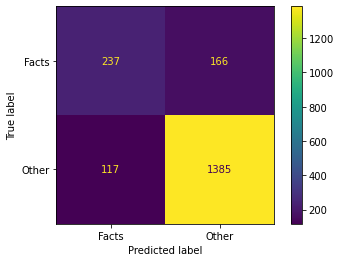

In [20]:
%%time
evaluate_with_test_set(default_mlp_trainer)

#### Linear SVM

In [21]:
from sklearn.svm import LinearSVC

def svm_trainer(X, y):
  svm = LinearSVC(random_state=1)
  return svm.fit(X, y)

In [22]:
%%time
cross_validation(svm_trainer)

### Evaluation with cross-validation ###
Starting fold 0


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Starting fold 1


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Starting fold 2


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Starting fold 3


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Starting fold 4
Mean precision - std deviation => train: 0.7707 0.0250 	 test: 0.6861 0.0977
Mean recall - std deviation    => train: 0.7855 0.0348 	 test: 0.6975 0.0779
Mean f1 - std deviation        => train: 0.7770 0.0107 	 test: 0.6826 0.0401
CPU times: user 58.5 s, sys: 649 ms, total: 59.1 s
Wall time: 58.1 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### Evaluation with the test set ###


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Precision: 0.6293
Recall:    0.7246
F-score:   0.6736
CPU times: user 15.5 s, sys: 132 ms, total: 15.6 s
Wall time: 15.4 s


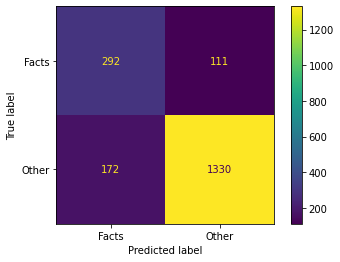

In [23]:
%%time
evaluate_with_test_set(svm_trainer)

#### RBF SVM

In [24]:
from sklearn.svm import SVC

def rbfsvm_trainer(X, y):
  rbfsvm = SVC(kernel='rbf', random_state=1)
  return rbfsvm.fit(X, y)

In [25]:
%%time

cross_validation(rbfsvm_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7426 0.0190 	 test: 0.7328 0.0765
Mean recall - std deviation    => train: 0.5803 0.0200 	 test: 0.5928 0.0945
Mean f1 - std deviation        => train: 0.6511 0.0110 	 test: 0.6473 0.0568
CPU times: user 2min 1s, sys: 279 ms, total: 2min 1s
Wall time: 2min 1s


### Evaluation with the test set ###
Precision: 0.6076
Recall:    0.5186
F-score:   0.5596
CPU times: user 24.2 s, sys: 73.2 ms, total: 24.3 s
Wall time: 24.1 s


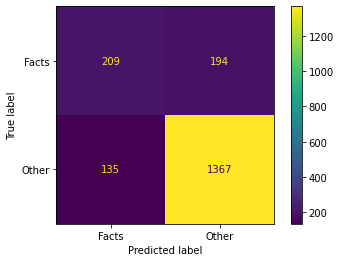

In [26]:
%%time

evaluate_with_test_set(rbfsvm_trainer)

#### Logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression

def lr_trainer(X, y):
  logreg = LogisticRegression(solver='sag', max_iter=200, random_state=1)
  return logreg.fit(X, y)

In [28]:
%%time

cross_validation(lr_trainer)

### Evaluation with cross-validation ###
Starting fold 0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Starting fold 1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Starting fold 2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Starting fold 3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Starting fold 4
Mean precision - std deviation => train: 0.8141 0.0058 	 test: 0.7315 0.0999
Mean recall - std deviation    => train: 0.7019 0.0132 	 test: 0.6446 0.1095
Mean f1 - std deviation        => train: 0.7538 0.0096 	 test: 0.6728 0.0570
CPU times: user 1min 1s, sys: 634 ms, total: 1min 1s
Wall time: 1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


### Evaluation with the test set ###


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Precision: 0.6578
Recall:    0.6154
F-score:   0.6359
CPU times: user 15.3 s, sys: 139 ms, total: 15.4 s
Wall time: 15.2 s


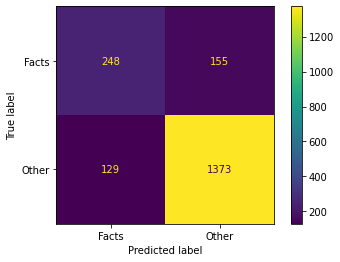

In [29]:
%%time

evaluate_with_test_set(lr_trainer)

#### KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

def knn_trainer(X, y):
  knn = KNeighborsClassifier(5)
  return knn.fit(X, y)

In [31]:
%%time

cross_validation(knn_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8249 0.0055 	 test: 0.7205 0.0709
Mean recall - std deviation    => train: 0.6464 0.0119 	 test: 0.5710 0.0987
Mean f1 - std deviation        => train: 0.7248 0.0085 	 test: 0.6273 0.0504
CPU times: user 30.4 s, sys: 4.16 s, total: 34.6 s
Wall time: 20 s


### Evaluation with the test set ###
Precision: 0.6587
Recall:    0.5459
F-score:   0.5970
CPU times: user 2.04 s, sys: 284 ms, total: 2.33 s
Wall time: 1.29 s


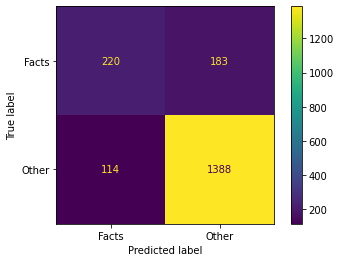

In [32]:
%%time

evaluate_with_test_set(knn_trainer)

#### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_trainer(X, y):
  dtree = DecisionTreeClassifier(random_state=1)
  return dtree.fit(X, y)

In [34]:
%%time

cross_validation(decision_tree_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9995 0.0002 	 test: 0.5518 0.0839
Mean recall - std deviation    => train: 1.0000 0.0000 	 test: 0.5707 0.0799
Mean f1 - std deviation        => train: 0.9998 0.0001 	 test: 0.5506 0.0274
CPU times: user 1min 27s, sys: 126 ms, total: 1min 27s
Wall time: 1min 26s


### Evaluation with the test set ###
Precision: 0.4778
Recall:    0.5062
F-score:   0.4916


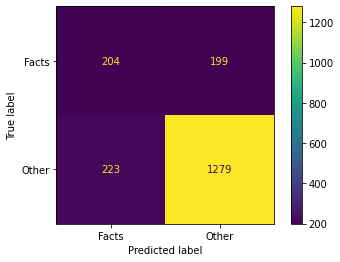

In [35]:
evaluate_with_test_set(decision_tree_trainer)

#### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_trainer(X, y):
  rforest = RandomForestClassifier(random_state=1)
  return rforest.fit(X, y)

In [37]:
cross_validation(random_forest_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9995 0.0002 	 test: 0.7500 0.0588
Mean recall - std deviation    => train: 0.9999 0.0002 	 test: 0.6167 0.1070
Mean f1 - std deviation        => train: 0.9997 0.0002 	 test: 0.6682 0.0602


### Evaluation with the test set ###
Precision: 0.6441
Recall:    0.5658
F-score:   0.6024


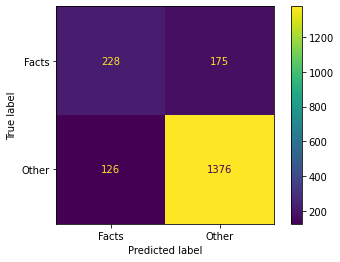

In [38]:
evaluate_with_test_set(random_forest_trainer)

#### AdaBoost

In [39]:
from sklearn.ensemble import AdaBoostClassifier

def adaboost_trainer(X, y):
  adab = AdaBoostClassifier(random_state=1)
  return adab.fit(X, y)

In [40]:
cross_validation(adaboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7820 0.0098 	 test: 0.7002 0.0507
Mean recall - std deviation    => train: 0.6794 0.0079 	 test: 0.6226 0.0901
Mean f1 - std deviation        => train: 0.7271 0.0077 	 test: 0.6522 0.0378


### Evaluation with the test set ###
Precision: 0.5944
Recall:    0.5782
F-score:   0.5862


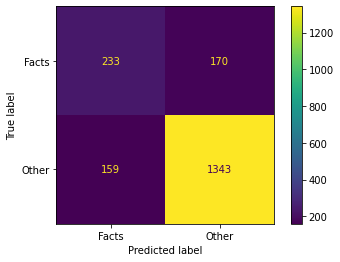

In [41]:
evaluate_with_test_set(adaboost_trainer)

#### Naive Bayes

In [42]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes_trainer(X, y):
  nb = GaussianNB()
  return nb.fit(X, y)


In [43]:
cross_validation(naive_bayes_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.4357 0.0361 	 test: 0.4349 0.0964
Mean recall - std deviation    => train: 0.8821 0.0095 	 test: 0.8837 0.0661
Mean f1 - std deviation        => train: 0.5822 0.0296 	 test: 0.5760 0.0789


### Evaluation with the test set ###
Precision: 0.3645
Recall:    0.7841
F-score:   0.4976


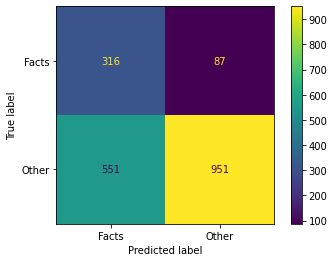

In [44]:
evaluate_with_test_set(naive_bayes_trainer)

#### XGBoost

In [45]:
from xgboost.sklearn import XGBClassifier
import torch

def xgboost_trainer(X, y):
  if torch.cuda.is_available():
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='gpu_hist', gpu_id=0)
  else:
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='hist')
  return xgboost.fit(X, y)


In [46]:
cross_validation(xgboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8781 0.0061 	 test: 0.7634 0.0524
Mean recall - std deviation    => train: 0.7367 0.0149 	 test: 0.6260 0.1012
Mean f1 - std deviation        => train: 0.8012 0.0107 	 test: 0.6801 0.0523


### Evaluation with the test set ###
Precision: 0.6583
Recall:    0.5831
F-score:   0.6184


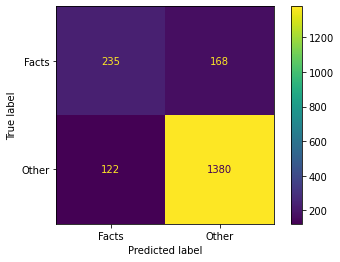

In [47]:
evaluate_with_test_set(xgboost_trainer)

### Results

In [48]:
from IPython.display import display, update_display

metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1'])
for model_name, metrics in test_metrics.items():
  metrics_df.loc[model_name] = [f'{metrics[0]:.4f}', f'{metrics[1]:.4f}', f'{metrics[2]:.4f}']
metrics_display = display(metrics_df, display_id='metrics_table')

,Precision,Recall,F1
MLPClassifier,0.6695,0.5881,0.6262
LinearSVC,0.6293,0.7246,0.6736
SVC,0.6076,0.5186,0.5596
LogisticRegression,0.6578,0.6154,0.6359
KNeighborsClassifier,0.6587,0.5459,0.5970
DecisionTreeClassifier,0.4778,0.5062,0.4916
RandomForestClassifier,0.6441,0.5658,0.6024
AdaBoostClassifier,0.5944,0.5782,0.5862
GaussianNB,0.3645,0.7841,0.4976
XGBClassifier,0.6583,0.5831,0.6184


### References:

- Paheli Bhattacharya, Shounak Paul, Kripabandhu Ghosh, Saptarshi Ghosh, and Adam Wyner. 2019. **Identification of Rhetorical Roles of Sentences in Indian Legal Judgments**. In Proc. International Conference on Legal Knowledge and Information Systems (JURIX).

- https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/